In [2]:
import time
import numpy as np
import cv2
from numpy import int16, uint8, log2
import pydvs.generate_spikes as gs
import cython
from testingcode.myfilters import singlenoisefilter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
import pickle
%matplotlib inline

In [3]:
#defines
#mode 16 32 64 128
#0 up polar 1 down 2 merge pollar
video_dev_id = 1
mode = "128"
cam_res = int(mode)
width = cam_res # square output
height = cam_res
shape = (height, width)
#cam_res = 256 # <- can be done, but spynnaker doesn't suppor such resolution

data_shift = uint8( log2(cam_res) )
up_down_shift = uint8(2*data_shift)
data_mask = uint8(cam_res - 1)

polarity = 2

history_weight = 1.0#1.0
threshold = 8 # ~ 0.05*255
max_threshold = 120 # 12*15 ~ 0.7*255

scale_width = 0
scale_height = 0
col_from = 0
col_to = 0

curr     = np.zeros(shape,     dtype=int16) 
ref      = 128*np.ones(shape,  dtype=int16) 
spikes   = np.zeros(shape,     dtype=int16) 
diff     = np.zeros(shape,     dtype=int16) 
abs_diff = np.zeros(shape,     dtype=int16) 

# just to see things in a window
spk_img  = np.zeros((height, width, 3), uint8)

num_bits = 6   # how many bits are used to represent exceeded thresholds
num_active_bits = 2 # how many of bits are active
log2_table = gs.generate_log2_table(num_active_bits, num_bits)[num_active_bits - 1]
spike_lists = None
pos_spks = None
neg_spks = None
max_diff = 0

# inhibition related                                                   #

inh_width = 2
is_inh_on = True
inh_coords = gs.generate_inh_coords(width, height, inh_width)
# camera/frequency related                                             #

video_dev = cv2.VideoCapture(video_dev_id) # webcam
#video_dev = cv2.VideoCapture('/path/to/video/file') # webcam

print(video_dev.isOpened())

#ps3 eyetoy can do 125fps
try:
  video_dev.set(cv2.CAP_PROP_FPS, 125)
except:
  pass
  
fps = video_dev.get(cv2.CAP_PROP_FPS)
if fps == 0.0:
  fps = 30.0
max_time_ms = int(1000./float(fps))


False


In [4]:

# -------------------------------------------------------------------- #
# grab / rescale frame                                                 #
def grab_first(dev, res):
  _, raw = dev.read()
  height, width, _ = raw.shape
  new_height = res
  new_width = int( float(new_height*width)/float(height) )
  col_from = (new_width - res)//2
  col_to   = col_from + res
  img = cv2.resize(cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY).astype(int16),(new_width, new_height))[:, col_from:col_to]
  return img, new_width, new_height, col_from, col_to

def grab_frame(dev, width, height, col_from, col_to):
  _, raw = dev.read()
  img = cv2.resize(cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY).astype(int16),
               (width, height))[:, col_from:col_to]

  return img

In [5]:
def Base_work(curr,spikes,elapsed):
    # get an image from video source
  curr[:] = grab_frame(video_dev, scale_width,  scale_height, col_from, col_to)
  #curr = cv2.medianBlur(curr,5)
  imgraw=np.zeros((128,128,3),np.uint8)
  imgraw[:,:,0]=curr
  imgraw[:,:,1]=curr
  imgraw[:,:,2]=curr
 
  # do the difference
  diff[:], abs_diff[:], spikes[:] = gs.thresholded_difference(curr, ref, threshold)
  
  # inhibition ( optional ) 
  if is_inh_on:
    spikes[:] = gs.local_inhibition(spikes, abs_diff, inh_coords, 
                                 width, height, inh_width)
  
  # update the reference
  ref[:] = gs.update_reference_time_binary_thresh(abs_diff, spikes, ref,
                                               threshold, max_time_ms,
                                               num_active_bits,
                                               history_weight,
                                               log2_table)
  
  # convert into a set of packages to send out
  neg_spks, pos_spks, max_diff = gs.split_spikes(spikes, abs_diff, polarity)
  
  # this takes too long, could be parallelized at expense of memory
  spike_lists = gs.make_spike_lists_time_bin_thr(pos_spks, neg_spks,
                                              max_diff,
                                              up_down_shift, data_shift, data_mask,
                                              max_time_ms,
                                              threshold, 
                                              max_threshold,
                                              num_bits,
                                              log2_table)
  
  spk_img[:] = gs.render_frame(spikes, curr, cam_res, cam_res, polarity)

  #show
  fm=np.copy(spk_img)
  #cv2.putText(cu,"O",(x[0],x[1]),cv2.FONT_HERSHEY_PLAIN,2,(8,255,8),1)
  fm=cv2.putText(fm,f'FPS: {int(elapsed)}',(10,10),cv2.FONT_HERSHEY_PLAIN,1,(8,255,8),1)
  fm=cv2.resize(fm,(600,600))
  cv2.imshow (WINDOW_NAME, fm) 
  return imgraw

In [6]:
def get_white_frame(spikes):
  rows,cols = np.where(spikes==-1)
  imgesR=np.zeros([width,height,1],np.uint8)
  imgesR[rows,cols]=255
  rows,cols = np.where(spikes==1)
  imgesG=np.zeros([width,height,1],np.uint8)
  imgesG[rows,cols]=255
  rows,cols = np.where(spikes!=0)
  imges=np.zeros([width,height,1],np.uint8)
  imges[rows,cols]=255
  return imgesR,imgesG,imges

In [7]:
def drawobject(figname,img):


  ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  #img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  imges11=np.zeros([width,height,3],np.uint8)
  cv2.drawContours(imges11,contours,-1,(80,60,0),3)
  #cv2.imshow('output1',imges11)

  try: hierarchy = hierarchy[0]
  except: hierarchy = []

  min_x, min_y = width, height
  max_x = max_y = 0

  ar=[]
      # computes the bounding box for the contour, and draws it on the frame,
  for contour, hier in zip(contours, hierarchy):
      (x,y,w,h) = cv2.boundingRect(contour)
      min_x, max_x = min(x, min_x), max(x+w, max_x)
      min_y, max_y = min(y, min_y), max(y+h, max_y)
      if w > 40 and h > 40  and w<150 and h<150:
          cv2.rectangle(imges11, (x,y), (x+w,y+h), (0, 0, 255), 2)
          ar.append([x,y,x+w,x+h])
  #if max_x - min_x > 10 and max_y - min_y > 10 and max_y - min_y < 150 and max_x - min_x<150:
  #    cv2.rectangle(imges11, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
  cv2.imshow(figname,imges11)
  return ar

In [8]:
def dvs_direction_detection(imgN,imgR,imgG):
    rb_count=np.count_nonzero(imgR[:,0:50])+np.count_nonzero(imgR[:,80:128])+np.count_nonzero(imgR[0:50,:])+np.count_nonzero(imgR[80:128,:])
    gb_count=np.count_nonzero(imgG[:,0:50])+np.count_nonzero(imgG[:,80:128])+np.count_nonzero(imgG[0:50,:])+np.count_nonzero(imgG[80:128,:])
    if rb_count > gb_count :
        return 'I'
    else :
        return 'O'
    text ="  R U :"+str(np.count_nonzero(imgR[:,0:50]))
    text +="  R D :"+str(np.count_nonzero(imgR[:,80:128]))
    text +="  R L :"+str(np.count_nonzero(imgR[0:50,:]))
    text +="  R R :"+str(np.count_nonzero(imgR[80:128,:]))

    text +="  G U :"+str(np.count_nonzero(imgG[:,0:50]))
    text +="  G D :"+str(np.count_nonzero(imgG[:,80:128]))
    text +="  G L :"+str(np.count_nonzero(imgG[0:50,:]))
    text +="  G R :"+str(np.count_nonzero(imgG[80:128,:]))
    return text

In [9]:
def base_filter(current,imgesR,imgesG,imges):
  rir=np.copy(imgesR)
  rig=np.copy(imgesG)
  rii=np.copy(imges)

  #sow all
  Hori = np.concatenate((imges, imgesR), axis=1)
  Hori = np.concatenate((Hori, imgesG), axis=1)
  cv2.imshow ("Hori   N  R   G", Hori)
  #sow filtered
  fi=np.zeros_like(rii)
  fr=np.zeros_like(rir)
  fg=np.zeros_like(rig)
  singlenoisefilter(fr,rir,128,3)
  singlenoisefilter(fg,rig,128,3)
  singlenoisefilter(fi,rii,128,3)

  Hori2 = np.concatenate((rii, rir), axis=1)
  Hori2 = np.concatenate((Hori2, rig), axis=1)
  cv2.imshow ("filtered   N  R   G", Hori2)

  #--------------------------------
  #adding some thing
  kernel = np.ones((5,5),np.uint8)
  dili = cv2.dilate(rii,kernel,iterations=3)
  dilr = cv2.dilate(rir,kernel,iterations=3)
  dilg = cv2.dilate(rig,kernel,iterations=3)

  Hori3 = np.concatenate((dili, dilr), axis=1)
  Hori3 = np.concatenate((Hori3, dilg), axis=1)
  cv2.imshow ("dil   N  R   G", Hori3)

  #draw count
  ar=drawobject("r countur",dilr)

  cu=current
  cu =cv2.resize(cu,(600,600))
  for x in ar:
      cv2.rectangle(cu, (x[0],x[1]), (x[2],x[3]), (0, 0, 255), 2)
      cv2.putText(cu,dvs_direction_detection(rii,rir,rig),(x[0],x[1]),cv2.FONT_HERSHEY_PLAIN,1,(8,255,8),1)
  
  cv2.namedWindow("object", cv2.WINDOW_AUTOSIZE)
  cv2.imshow ("object", cu)
  
  imgG = dilg
  imgR = dilr
  img  = dili

  return img,imgG,imgR

In [10]:
listofframeI =[]
listofframeR =[]
listofframeG =[]
listofframeC =[]

In [57]:
#---------------------- main loop -------------------------------------#
LOOP_START =True
if video_dev.isOpened()==False:
    print("error in camera")
    LOOP_START = False
    

WINDOW_NAME = 'spikes'
cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
cv2.startWindowThread()

is_first_pass = True
start_time = time.time()
end_time = 0
frame_count = 0

pTime =0
fpss=0
curr[:], scale_width, scale_height, col_from, col_to = grab_first(video_dev, cam_res)
while(LOOP_START):
  #get spikes and prepare them  
  d3img=Base_work(curr,spikes,fpss)
  

  #get spike on white frame
  imgesR,imgesG,imges = get_white_frame(spikes)

  #---------------------------------------------------
  #first filter
  img,imgG,imgR = base_filter(d3img,imgesR.squeeze(),imgesG.squeeze(),imges.squeeze())

 
  #==============================================================
  key =cv2.waitKey(1)
  if  key& 0xFF == ord('q'):
    break
  if key & 0xFF == ord('c'):

    imgesR,imgesG,imges = get_white_frame(spikes)
    listofframeR.append(imgesR.squeeze())
    listofframeG.append(imgesG.squeeze())
    listofframeI.append(imges.squeeze())
    listofframeC.append(d3img)
    

  end_time = time.time()
  
  if end_time - start_time >= 1.0:
    fpss=frame_count
    #print("%d frames per second"%(frame_count))
    frame_count = 0
    start_time = time.time()
  else:
    frame_count += 1
  

cv2.destroyAllWindows()

In [58]:
from time import sleep
print(len(listofframeI))
img_index =0
mapimage = np.zeros((128,128,3),np.uint8)
#-----------------------------------------------------------------
while True:  
    #img_index = 148
    cv2.imshow("main",listofframeC[img_index])
    
    Hori = np.concatenate((listofframeI[img_index], listofframeR[img_index]), axis=1)
    Hori = np.concatenate((Hori, listofframeG[img_index]), axis=1)
    cv2.imshow ("Hori   N  R   G", Hori)
    print("index :",img_index)

    rir = np.copy(listofframeR[img_index])
    rig = np.copy(listofframeG[img_index])
    rii = np.copy(listofframeI[img_index])

    mapimage[:,:,1]=rir
    mapimage[:,:,2]=rig
    cv2.imshow ("colored map", mapimage)



    #sow filtered
    fi=np.zeros_like(rii)
    fr=np.zeros_like(rir)
    fg=np.zeros_like(rig)
    singlenoisefilter(fr,rir,128,3)
    singlenoisefilter(fg,rig,128,3)
    singlenoisefilter(fi,rii,128,3)

    Hori2 = np.concatenate((rii, rir), axis=1)
    Hori2 = np.concatenate((Hori2, rig), axis=1)
    cv2.imshow ("filtered   N  R   G", Hori2)

    #--------------------------------
    #adding some thing
    kernel = np.ones((5,5),np.uint8)
    dili = cv2.dilate(rii,kernel,iterations=1)
    dilr = cv2.dilate(rir,kernel,iterations=5)
    dilg = cv2.dilate(rig,kernel,iterations=1)

    Hori3 = np.concatenate((dili, dilr), axis=1)
    Hori3 = np.concatenate((Hori3, dilg), axis=1)
    cv2.imshow ("dil   N  R   G", Hori3)

    #draw count
    ar=drawobject("r countur",dilr)

    cu=listofframeC[img_index]
    cu =cv2.resize(cu,(600,600))
    for x in ar:
        cv2.rectangle(cu, (x[0],x[1]), (x[2],x[3]), (0, 0, 255), 2)
        cv2.putText(cu,dvs_direction_detection(rii,rir,rig),(x[0],x[1]),cv2.FONT_HERSHEY_PLAIN,1,(8,255,8),1)
    
    cv2.namedWindow("object", cv2.WINDOW_AUTOSIZE)
    cv2.imshow ("object", cu)




    #controlls --------------------------------------------------------------------
    breakfag= False
    while True:
        key=cv2.waitKey(0)
        if  key& 0xFF == ord('q'):
            breakfag = True
            break
        if key & 0xFF == ord('6'):
            img_index+=1
            if img_index >=len(listofframeI):
                img_index =0
            break
        if key & 0xFF == ord('4'):
            img_index-=1
            break
    if breakfag == True:
        break  
    #-------------------------------------------------------------------------------
cv2.destroyAllWindows()

448
index : 0
index : 1
index : 0
index : -1
index : -2
index : -3
index : -2
index : -1
index : 0
index : -1
index : -2
index : -3
index : -4
index : -5
index : -6
index : -7
index : -8
index : -9
index : -10
index : -11
index : -12
index : -13
index : -14
index : -15
index : -16
index : -17
index : -18
index : -19
index : -20
index : -21
index : -22
index : -23
index : -24
index : -25
index : -26
index : -27
index : -28
index : -29
index : -30
index : -31
index : -32
index : -33
index : -34
index : -35
index : -36
index : -37
index : -38
index : -39
index : -40
index : -41
index : -42
index : -43
index : -44
index : -45
index : -46
index : -47
index : -48
index : -49
index : -50
index : -51
index : -52
index : -53
index : -54
index : -55
index : -56
index : -57
index : -58
index : -59
index : -60
index : -61
index : -62
index : -63
index : -64
index : -65
index : -66
index : -67
index : -68
index : -69
index : -70
index : -71
index : -72
index : -73
index : -74
index : -75
index : -7

In [21]:
#testing ...

main
index : 143
colored map
filtered   N  R   G
dil   N  R   G


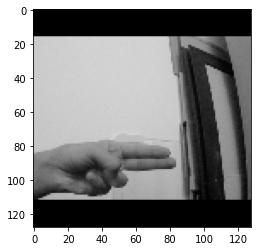

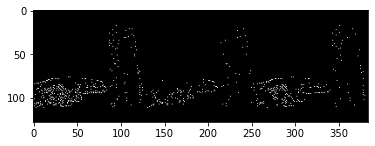

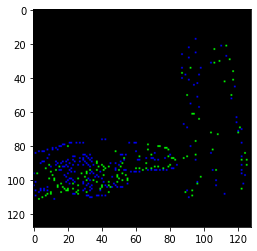

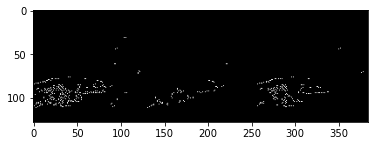

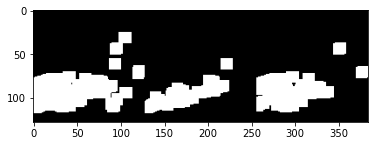

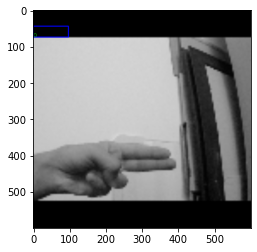

In [19]:
img_index = 151-8
print("main")
plt.figure()
plt.imshow(listofframeC[img_index])

Hori = np.concatenate((listofframeI[img_index], listofframeR[img_index]), axis=1)
Hori = np.concatenate((Hori, listofframeG[img_index]), axis=1)
plt.figure()
plt.imshow ( Hori, cmap='gray', vmin=0, vmax=255)
print("index :",img_index)


rir = np.copy(listofframeR[img_index])
rig = np.copy(listofframeG[img_index])
rii = np.copy(listofframeI[img_index])

mapimage[:,:,1]=rir
mapimage[:,:,2]=rig
print("colored map")
plt.figure()
plt.imshow (mapimage)



#sow filtered
fi=np.zeros_like(rii)
fr=np.zeros_like(rir)
fg=np.zeros_like(rig)
singlenoisefilter(fr,rir,128,2)
singlenoisefilter(fg,rig,128,2)
singlenoisefilter(fi,rii,128,2)

Hori2 = np.concatenate((rii, rir), axis=1)
Hori2 = np.concatenate((Hori2, rig), axis=1)
print("filtered   N  R   G")
plt.figure()
plt.imshow (Hori2, cmap='gray', vmin=0, vmax=255)

#--------------------------------
#adding some thing
kernel = np.ones((5,5),np.uint8)
dili = cv2.dilate(rii,kernel,iterations=3)
dilr = cv2.dilate(rir,kernel,iterations=3)
dilg = cv2.dilate(rig,kernel,iterations=3)

Hori3 = np.concatenate((dili, dilr), axis=1)
Hori3 = np.concatenate((Hori3, dilg), axis=1)
print("dil   N  R   G")
plt.figure()
plt.imshow (Hori3, cmap='gray', vmin=0, vmax=255)

#draw count
ar=drawobject("r countur",dilr)

cu=listofframeC[img_index]
cu =cv2.resize(cu,(600,600))
for x in ar:
    cv2.rectangle(cu, (x[0],x[1]), (x[2],x[3]), (0, 0, 255), 2)
    cv2.putText(cu,dvs_direction_detection(rii,rir,rig),(x[0],x[1]),cv2.FONT_HERSHEY_PLAIN,1,(8,255,8),1)
plt.figure()
plt.imshow (cu)

plt.show()

In [16]:
Idat= open("iDatapy.dat",'wb')
Rdat= open("rDatapy.dat",'wb')
Gdat= open("gDatapy.dat",'wb')
Cdat= open("cDatapy.dat",'wb')

pickle.dump(listofframeI,Idat)
pickle.dump(listofframeR,Rdat)
pickle.dump(listofframeG,Gdat)
pickle.dump(listofframeC,Cdat)

Idat.close()
Rdat.close()
Gdat.close()
Cdat.close()

In [11]:
listofframeI =[]
listofframeR =[]
listofframeG =[]
listofframeC =[]

Idat= open("iDatapy.dat",'rb')
Rdat= open("rDatapy.dat",'rb')
Gdat= open("gDatapy.dat",'rb')
Cdat= open("cDatapy.dat",'rb')

listofframeI=pickle.load(Idat)
listofframeR=pickle.load(Rdat)
listofframeG=pickle.load(Gdat)
listofframeC=pickle.load(Cdat)

Idat.close()
Rdat.close()
Gdat.close()
Cdat.close()

main
index : 14
colored map
filtered   N  R   G
dil   N  R   G


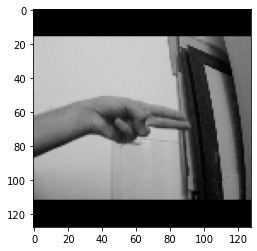

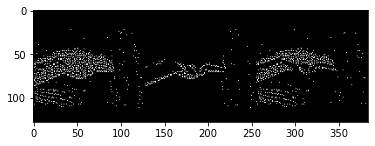

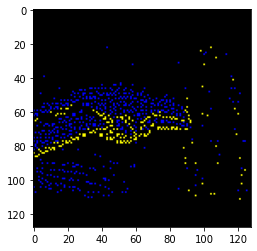

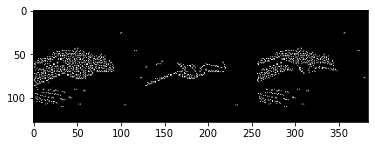

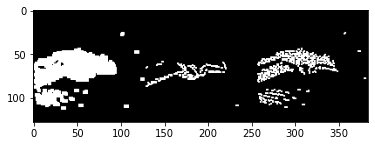

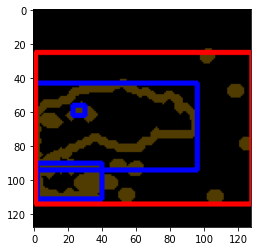

In [40]:
#14 down
#28 up
#252 right
#265 left 
#165 front
#177 back


img_index =14

print("main")
plt.figure()
plt.imshow(listofframeC[img_index])

Hori = np.concatenate((listofframeI[img_index], listofframeR[img_index]), axis=1)
Hori = np.concatenate((Hori, listofframeG[img_index]), axis=1)
plt.figure()
plt.imshow ( Hori, cmap='gray', vmin=0, vmax=255)
print("index :",img_index)


rir = np.copy(listofframeR[img_index])
rig = np.copy(listofframeG[img_index])
rii = np.copy(listofframeI[img_index])

mapimage[:,:,1]=rir
mapimage[:,:,2]=rig
print("colored map")
plt.figure()
plt.imshow (mapimage)

#sow filtered
fi=np.zeros_like(rii)
fr=np.zeros_like(rir)
fg=np.zeros_like(rig)
singlenoisefilter(fr,rir,128,2)
singlenoisefilter(fg,rig,128,2)
singlenoisefilter(fi,rii,128,2)

Hori2 = np.concatenate((rii, rir), axis=1)
Hori2 = np.concatenate((Hori2, rig), axis=1)
print("filtered   N  R   G")
plt.figure()
plt.imshow (Hori2, cmap='gray', vmin=0, vmax=255)

#--------------------------------
#adding some thing
kernel = np.ones((2,2),np.uint8)
dili = cv2.dilate(rii,kernel,iterations=3)
dilr = cv2.dilate(rir,kernel,iterations=1)
dilg = cv2.dilate(rig,kernel,iterations=1)

Hori3 = np.concatenate((dili, dilr), axis=1)
Hori3 = np.concatenate((Hori3, dilg), axis=1)
print("dil   N  R   G")
plt.figure()
plt.imshow (Hori3, cmap='gray', vmin=0, vmax=255)



#-----------------------------------------------
ret,thresh = cv2.threshold(dili,127,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
#img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
imges11=np.zeros([width,height,3],np.uint8)
cv2.drawContours(imges11,contours,-1,(80,60,0),3)
#cv2.imshow('output1',imges11)

try: hierarchy = hierarchy[0]
except: hierarchy = []

min_x, min_y = width, height
max_x = max_y = 0

ar=[]
    # computes the bounding box for the contour, and draws it on the frame,
for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv2.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    if w > 5 and h > 5  and w<200 and h<200:
        cv2.rectangle(imges11, (x,y), (x+w,y+h), (0, 0, 255), 2)
        ar.append([x,y,x+w,x+h])
if max_x - min_x > 10 and max_y - min_y > 10 and max_y - min_y < 150 and max_x - min_x<150:
    cv2.rectangle(imges11, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
plt.figure()
plt.imshow (imges11)


main
index : 252
colored map
filtered   N  R   G
dil   N  R   G


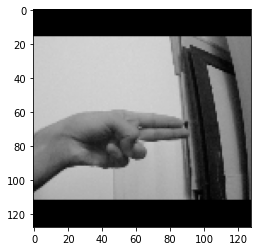

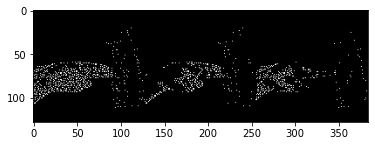

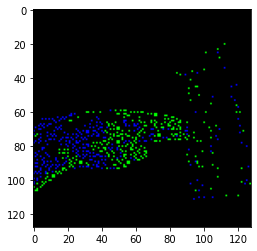

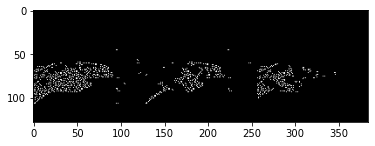

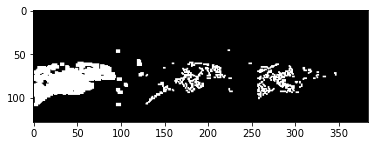

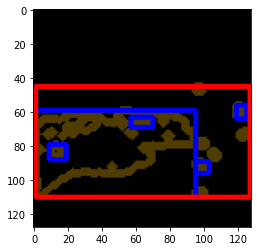

In [42]:
#14 down
#28 up
#252 right
#265 left 
#165 front
#177 back


img_index =252

print("main")
plt.figure()
plt.imshow(listofframeC[img_index])

Hori = np.concatenate((listofframeI[img_index], listofframeR[img_index]), axis=1)
Hori = np.concatenate((Hori, listofframeG[img_index]), axis=1)
plt.figure()
plt.imshow ( Hori, cmap='gray', vmin=0, vmax=255)
print("index :",img_index)


rir = np.copy(listofframeR[img_index])
rig = np.copy(listofframeG[img_index])
rii = np.copy(listofframeI[img_index])
mapimage[:,:,0]=0
mapimage[:,:,1]=rir
mapimage[:,:,2]=rig
print("colored map")
plt.figure()
plt.imshow (mapimage)

#sow filtered
fi=np.zeros_like(rii)
fr=np.zeros_like(rir)
fg=np.zeros_like(rig)
singlenoisefilter(fr,rir,128,2)
singlenoisefilter(fg,rig,128,2)
singlenoisefilter(fi,rii,128,2)

Hori2 = np.concatenate((rii, rir), axis=1)
Hori2 = np.concatenate((Hori2, rig), axis=1)
print("filtered   N  R   G")
plt.figure()
plt.imshow (Hori2, cmap='gray', vmin=0, vmax=255)

#--------------------------------
#adding some thing
kernel = np.ones((2,2),np.uint8)
dili = cv2.dilate(rii,kernel,iterations=3)
dilr = cv2.dilate(rir,kernel,iterations=1)
dilg = cv2.dilate(rig,kernel,iterations=1)

Hori3 = np.concatenate((dili, dilr), axis=1)
Hori3 = np.concatenate((Hori3, dilg), axis=1)
print("dil   N  R   G")
plt.figure()
plt.imshow (Hori3, cmap='gray', vmin=0, vmax=255)



#-----------------------------------------------
ret,thresh = cv2.threshold(dili,127,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
#img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
imges11=np.zeros([width,height,3],np.uint8)
cv2.drawContours(imges11,contours,-1,(80,60,0),3)
#cv2.imshow('output1',imges11)

try: hierarchy = hierarchy[0]
except: hierarchy = []

min_x, min_y = width, height
max_x = max_y = 0

ar=[]
    # computes the bounding box for the contour, and draws it on the frame,
for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv2.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    if w > 5 and h > 5  and w<200 and h<200:
        cv2.rectangle(imges11, (x,y), (x+w,y+h), (0, 0, 255), 2)
        ar.append([x,y,x+w,x+h])
if max_x - min_x > 10 and max_y - min_y > 10 and max_y - min_y < 150 and max_x - min_x<150:
    cv2.rectangle(imges11, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
plt.figure()
plt.imshow (imges11)


In [15]:
 def sampleTester(indexer):
    #14 down
    #28 up
    #252 right
    #265 left 
    #165 front
    #177 back


    img_index =indexer

    print("main")
    plt.figure()
    plt.imshow(listofframeC[img_index])

    Hori = np.concatenate((listofframeI[img_index], listofframeR[img_index]), axis=1)
    Hori = np.concatenate((Hori, listofframeG[img_index]), axis=1)
    plt.figure()
    plt.imshow ( Hori, cmap='gray', vmin=0, vmax=255)
    print("index :",img_index)

    mapimage=np.zeros((128,128,3),np.uint8)


    rir = np.copy(listofframeR[img_index])
    rig = np.copy(listofframeG[img_index])
    rii = np.copy(listofframeI[img_index])
    mapimage[:,:,0]=0
    mapimage[:,:,1]=rir
    mapimage[:,:,2]=rig
    print("colored map")
    plt.figure()
    plt.imshow (mapimage)

    #sow filtered
    fi=np.zeros_like(rii)
    fr=np.zeros_like(rir)
    fg=np.zeros_like(rig)
    singlenoisefilter(fr,rir,128,2)
    singlenoisefilter(fg,rig,128,2)
    singlenoisefilter(fi,rii,128,2)

    Hori2 = np.concatenate((rii, rir), axis=1)
    Hori2 = np.concatenate((Hori2, rig), axis=1)
    print("filtered   N  R   G")
    plt.figure()
    plt.imshow (Hori2, cmap='gray', vmin=0, vmax=255)

    #--------------------------------
    #adding some thing
    kernel = np.ones((2,2),np.uint8)
    dili = cv2.dilate(rii,kernel,iterations=3)
    dilr = cv2.dilate(rir,kernel,iterations=1)
    dilg = cv2.dilate(rig,kernel,iterations=1)

    Hori3 = np.concatenate((dili, dilr), axis=1)
    Hori3 = np.concatenate((Hori3, dilg), axis=1)
    print("dil   N  R   G")
    plt.figure()
    plt.imshow (Hori3, cmap='gray', vmin=0, vmax=255)



    #-----------------------------------------------
    ret,thresh = cv2.threshold(dili,127,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    #img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    imges11=np.zeros([width,height,3],np.uint8)
    cv2.drawContours(imges11,contours,-1,(80,60,0),3)
    #cv2.imshow('output1',imges11)

    try: hierarchy = hierarchy[0]
    except: hierarchy = []

    min_x, min_y = width, height
    max_x = max_y = 0

    ar=[]
        # computes the bounding box for the contour, and draws it on the frame,
    for contour, hier in zip(contours, hierarchy):
        (x,y,w,h) = cv2.boundingRect(contour)
        min_x, max_x = min(x, min_x), max(x+w, max_x)
        min_y, max_y = min(y, min_y), max(y+h, max_y)
        if w > 5 and h > 5  and w<200 and h<200:
            cv2.rectangle(imges11, (x,y), (x+w,y+h), (0, 0, 255), 2)
            ar.append([x,y,x+w,x+h])
    if max_x - min_x > 10 and max_y - min_y > 10 and max_y - min_y < 150 and max_x - min_x<150:
        cv2.rectangle(imges11, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
    plt.figure()
    plt.imshow (imges11)



main
index : 14
colored map
filtered   N  R   G
dil   N  R   G
main
index : 177
colored map
filtered   N  R   G
dil   N  R   G
main
index : 165
colored map
filtered   N  R   G
dil   N  R   G
main
index : 28
colored map
filtered   N  R   G
dil   N  R   G


<ipython-input-15-8f5322bfd927>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


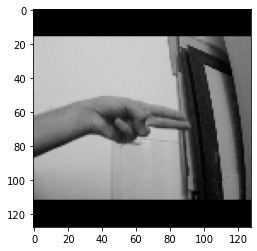

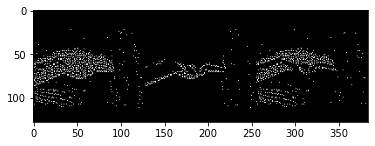

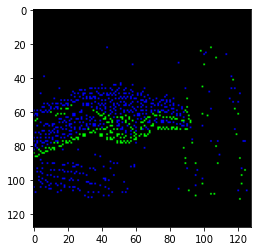

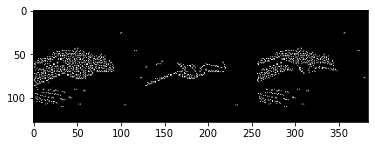

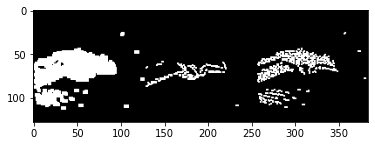

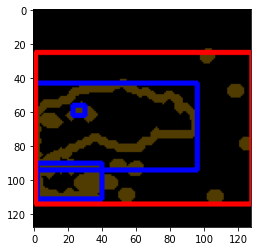

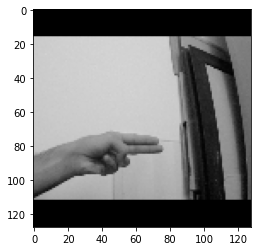

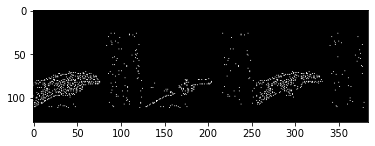

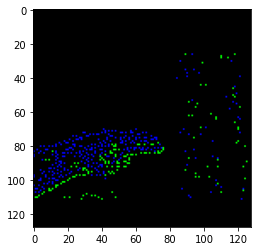

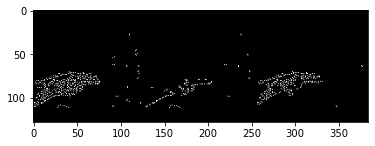

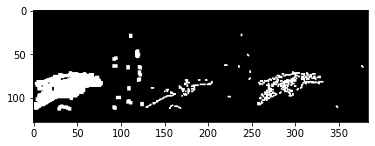

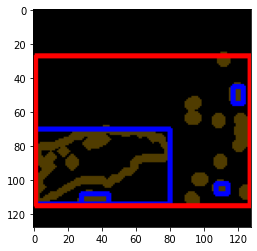

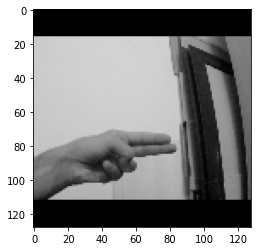

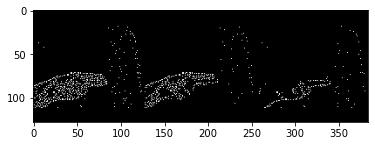

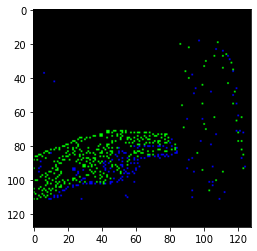

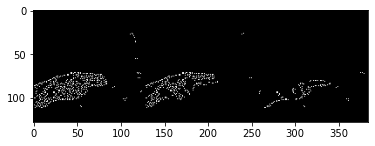

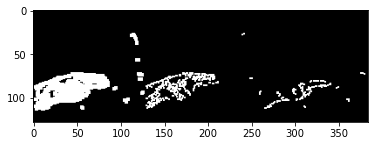

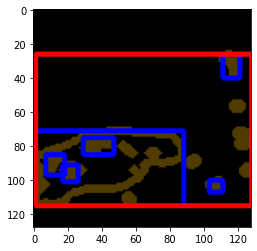

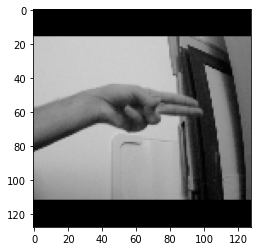

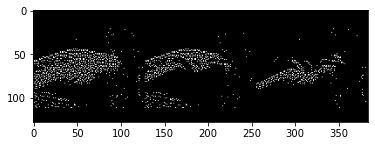

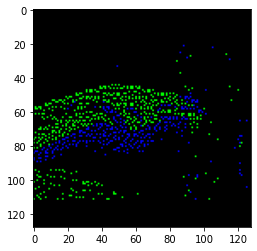

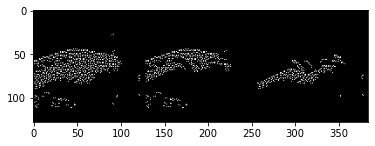

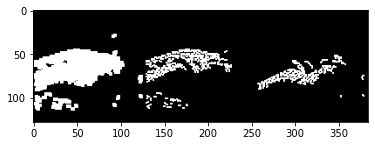

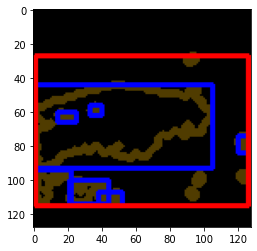

In [16]:
sampleTester(14)
sampleTester(177)
sampleTester(165)
sampleTester(28)